In [1]:
import numpy as np
import matplotlib.pyplot as plt
from run import agents, run
from numpy.typing import NDArray
from typing import NamedTuple, Sequence, Tuple
from deepsea import MultiRewardsDeepSea
import multiprocessing as mp
from scipy.stats import t as tstudent
import torch
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

class Results(NamedTuple):
    training_rewards: NDArray[np.float64]
    greedy_rewards: Sequence[Tuple[int, NDArray[np.float64]]]
    regret: NDArray[np.float64]
    
def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)
data = {}

2023-04-06 19:32:37.422233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 19:32:37.617281: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-06 19:32:37.621492: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alessio/.mujoco/mujoco210/bin
2023-04-06 19:32:37.621513: I tensorflow/compi

In [10]:
N_EPISODES = 1000
FREQ_EVAL_GREEDY = 100
NUM_EVAL_GREEDY = 20
NUM_PROC = 4
NUM_RUNS = 4
SIZE = 20
MAX_REWARD = 1
SLIPPING_PROBABILITY = 0.

def run_agent(agent_name: str, seed: int, multi_rewards: bool):
    torch.set_num_threads(2)
    #torch.set_num_interop_threads(2)
    make_env = lambda: MultiRewardsDeepSea(SIZE, MAX_REWARD,
                                           enable_multi_rewards=multi_rewards,
                                           slipping_probability=SLIPPING_PROBABILITY,
                                           randomize=True,
                                           seed=seed)
    return run(agent_name, N_EPISODES, make_env, FREQ_EVAL_GREEDY, NUM_EVAL_GREEDY, verbose=True)


with mp.Pool(NUM_PROC) as pool:
    for multi_rewards in [True]:
        key_dict = f'multi_rewards_enabled_{multi_rewards}'
        if key_dict not in data:
            data[key_dict] = {}
        for agent_name in ['boot_dqn_torch', 'explorative_generative_off_policy']:
            print(f'Running agent {agent_name} - multi_rewards {multi_rewards}')
            training_rewards, greedy_rewards, regret = zip(*pool.starmap(
                run_agent, [(agent_name, idx, multi_rewards) for idx in range(NUM_RUNS)]))
            data[key_dict][agent_name] = Results(training_rewards, greedy_rewards, regret)
 

Ep. 1 - Regret: 1.989 - Last 10 ep. avg ret. -0.004 - Last greedy avg. ret. 0 (std 0):   0%|          | 0/1000 [00:00<?, ?it/s] 00:00<?, ?it/s]

Running agent boot_dqn_torch - multi_rewards True


Ep. 999 - Regret: 200.047 - Last 10 ep. avg ret. 0.894 - Last greedy avg. ret. 0.943 (std 0.218): 100%|██████████| 1000/1000 [08:03<00:00,  2.07it/s]
Ep. 986 - Regret: 195.289 - Last 10 ep. avg ret. 0.794 - Last greedy avg. ret. 0.546 (std 0.497):  99%|█████████▊| 987/1000 [08:06<00:07,  1.65it/s]]
Ep. 999 - Regret: 201.979 - Last 10 ep. avg ret. 0.994 - Last greedy avg. ret. 0.146 (std 0.357): 100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s]
Ep. 999 - Regret: 196.242 - Last 10 ep. avg ret. 0.994 - Last greedy avg. ret. 0.144 (std 0.357): 100%|██████████| 1000/1000 [08:09<00:00,  2.04it/s]
Ep. 3 - Regret: 2.982 - Last 10 ep. avg ret. 0.328 - Last greedy avg. ret. 0 (std 0):   0%|          | 0/1000 [00:00<?, ?it/s]  

Running agent explorative_generative_off_policy - multi_rewards True


Ep. 999 - Regret: 99.352 - Last 10 ep. avg ret. 0.896 - Last greedy avg. ret. 0.049 (std 0.218): 100%|██████████| 1000/1000 [26:47<00:00,  1.61s/it]
Ep. 999 - Regret: 124.811 - Last 10 ep. avg ret. 0.896 - Last greedy avg. ret. 0.045 (std 0.218): 100%|██████████| 1000/1000 [26:54<00:00,  1.61s/it]
Ep. 999 - Regret: 106.31 - Last 10 ep. avg ret. 0.896 - Last greedy avg. ret. 0.046 (std 0.218): 100%|██████████| 1000/1000 [26:59<00:00,  1.62s/it]
Ep. 999 - Regret: 116.734 - Last 10 ep. avg ret. 0.896 - Last greedy avg. ret. 0.047 (std 0.218): 100%|██████████| 1000/1000 [27:04<00:00,  1.62s/it]


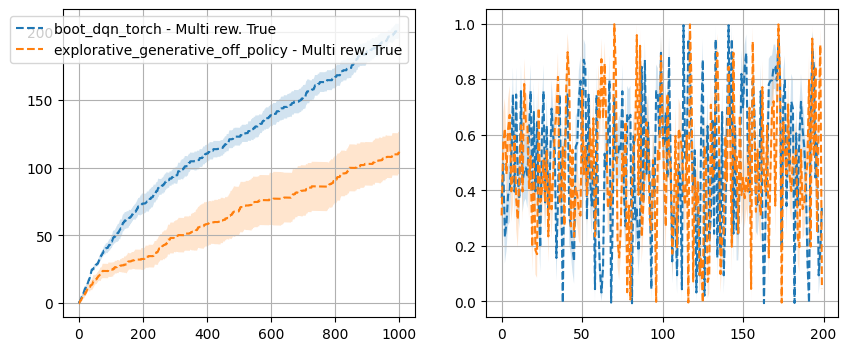

In [12]:
styles = {
    True: '--',
    False: '-'
}
fig, ax = plt.subplots(1,2, figsize=(10,4))

for multi_rewards in [True]:
    for agent_name in ['boot_dqn_torch','explorative_generative_off_policy']:
        agent_data = data[f'multi_rewards_enabled_{multi_rewards}'][agent_name]
        mu, ce = CE(np.array(agent_data.regret))

        t = np.arange(N_EPISODES + 1)
        ax[0].plot(t, mu, label=f'{agent_name} - Multi rew. {multi_rewards}', linestyle=styles[multi_rewards])
        ax[0].fill_between(t, np.clip(mu-ce,0,np.infty), mu+ce, alpha=0.2)
        
        greedy_data = np.array([list(zip(*agent_data.greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

        mu, ce = CE(greedy_data.swapaxes(1,2).reshape(-1, greedy_data.shape[1]))
        x = range(len(mu))
        ax[1].plot(x, mu, linestyle=styles[multi_rewards])
        ax[1].fill_between(x, np.clip(mu-ce,0, np.infty), mu+ce, alpha=0.2)

ax[0].grid()
ax[1].grid()
ax[0].legend()

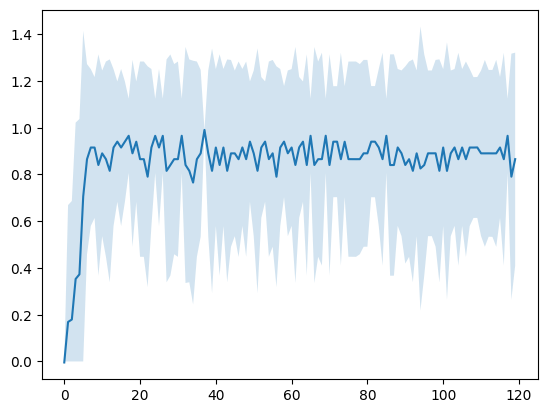

In [7]:
greedy_data = np.array([list(zip(*data['multi_rewards_enabled_False']['boot_dqn_torch'].greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

mu_groups, std_groups = greedy_data.mean(-1), greedy_data.std(-1, ddof=1)
RSS, ESS = std_groups.mean(0), mu_groups.std(0, ddof=1)
mu, std = mu_groups.mean(0), RSS+ESS


alpha = .95 + (1-.95)/2
c = tstudent.ppf(alpha, 5)
se = c * std/ np.sqrt(5)

x = range(len(mu))
plt.plot(x, mu)
plt.fill_between(x, np.clip(mu-se,0, np.infty), mu+se, alpha=0.2)

#plt.plot(x, ESS)